## Transformers for Language Modeling 

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install tiktoken
!pip install cohere
!pip install openai
import tiktoken

In [34]:
#why i chose this dataset: this dataset is sourced from kaggle and contains nearly all poems from the Poetry Foundation Website.
#its ranked 10 for usability, and contains about 2000 poems by robert frost and william woodsworth, as a fond enjoyer of poetry i wanted to generate some of my own :P

In [35]:
BATCH_SIZE = 32
BLOCK_SIZE = 8

# Create tiktoken object
encoder = tiktoken.get_encoding("gpt2")
file_path = "/content/poems.txt"
with open(file_path, "r") as f:
    poems_text = f.read()

encoded_ids = encoder.encode_ordinary(poems_text)

def get_batch():
    '''
    Returns a batch (x, y) from the dataset
    '''
    indices = np.random.randint(0, len(encoded_ids) - BLOCK_SIZE, BATCH_SIZE)
    x = [encoded_ids[i:i+BLOCK_SIZE] for i in indices]
    y = [encoded_ids[i+1:i+BLOCK_SIZE+1] for i in indices]
    x = torch.tensor(x, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)

    return x, y

xb, yb = get_batch()
xb.shape, yb.shape

(torch.Size([32, 8]), torch.Size([32, 8]))

## Creating the Transformer

### Defining our Hyperparameters 

We will define our hyperparameters here. 

Since there are lots of hyperparameters to keep track of, it is easier for me to wrap all of them inside a `dataclass`. This can be passed around very easily to different functions, and makes it easier to keep track of all relevant values.

To quickly describe some of the hyperparameters:

1. `block_size`: This is the length of the sequence that we will be feeding into our model. This has also been called the *context length* and *window size* in other places.

2. `emb_dim`: This is the dimensionality of the embeddings we will have inside the model. This has implications on the outputs of tensors throughout the entire model.

3. `head_size`: When dealing with Multi-Head Attention, we will be *splitting* our embeddings into multiple heads. This is the size of each of those heads. For example, if we had an embedding of size 512, and we wanted 8 heads, then each head would have a size of 64. 

4. `num_heads`: This is the number of attention heads we will have in our Multi-Head Attention layer.

5. `num_layers`: This is the number of layers we will have in our Transformer (this includes the MHSA, the Feedforward module, and the Layer Normalizations).

6. `vocab_size`: This is the size of our vocabulary. This is the number of unique tokens we have in our vocabulary. If we were to use character-level tokenization, this would be the number of unique characters in the dataset. Since we are using subword-level tokenization, this will be the number of unique subwords in the dataset.

In [36]:
from dataclasses import dataclass

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = encoder.n_vocab

config = Config()
assert config.emb_dim == config.head_size * config.num_heads, "Embedding dimension must be divisible by number of heads"

### Multi-Head Self-Attention

This component is the core of the Transformer. This is where the model learns to attend to different parts of the input sequence, and is the reason why Transformers are so powerful.

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

$$\text{head}_k = \text{Attention}(QW^Q_k, KW^K_k, VW^V_k)$$

$$\text{MHSA}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

For simplicity, assume we have a single Head:

1. The input has three parts extracted from it: the query $Q$, the key $K$, and the value $V$ (via projections or `Linear` layers).

2. The query and key are multiplied together to get a score. This score is then scaled by the square root of the embedding dimension, $\sqrt{d_k}$, then passed through a softmax to get the attention weights (*after* a masking operation is applied).

3. The attention weights are then multiplied with the value to get the final output.

When we extend this to *multiple heads*, we simply repeat this process for each head in parallel, and then concatenate the outputs of each head together.


In [37]:
class MHSA(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb_dim = cfg.emb_dim
        self.head_size = cfg.head_size
        self.block_size = cfg.block_size
        self.num_heads = cfg.num_heads
        self.projection_qkv = nn.Linear(self.emb_dim, 3 * self.emb_dim)
        self.projection_out = nn.Linear(self.emb_dim, self.emb_dim)

        self.register_buffer("mask", torch.tril(torch.ones(1, 1, self.block_size, self.block_size))) #changed for gen masks vs training masks

    def forward(self, x):

        B, T, C = x.shape # batch size, block size, emb dim
        H = self.num_heads

        qkv = self.projection_qkv(x).view(B, T, H, 3 * self.head_size)
        q, k, v = qkv.chunk(3, dim=-1)
        q = q.view(B, T, H, self.head_size)
        k = k.view(B, T, H, self.head_size)
        v = v.view(B, T, H, self.head_size)

        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_size).float())
        scores = scores.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attention_weights = F.softmax(scores, dim=-1)

        out = torch.matmul(attention_weights, v).view(B, T, H * self.head_size)
        out = self.projection_out(out)

        return out

x = torch.randn(32, config.block_size, config.emb_dim)
print(x.shape)
csa = MHSA(config)
out = csa(x)
print(out.shape)

torch.Size([32, 8, 256])
torch.Size([32, 8, 256])


### Feedforward Network 

The Feedforward Network module usually consists of two linear layers, with a ReLU activation in between. The first linear layer projects the input's Embeddings to a higher dimensionality (by a factor of 4 specifically), and the second linear layer projects it back down to the original dimensionality. This is a very simple module, but is very effective in learning complex functions.

In [38]:
class Feedforward(nn.Module):
    def __init__(self, config):
        super().__init__()
        emb_dim = config.emb_dim

        self.feedforward_network = nn.Sequential(
            nn.Linear(emb_dim, 2 * emb_dim),
            nn.GELU(),
            nn.Linear(2 * emb_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
    
        out = self.feedforward_network(x)
        return out

### Blocks with Skip Connections

The Encoder consists of multiple *Blocks*, that each contain a Multi-Head Self-Attention module, a Feedforward module, and a Layer Normalization module. We use Skip Connections to help with the flow of gradients during the training process.

In [39]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.mhsa = MHSA(config)
        self.feedforward = Feedforward(config)
        self.layer_norm1 = nn.LayerNorm(config.emb_dim)
        self.layer_norm2 = nn.LayerNorm(config.emb_dim)


    def forward(self, x):

        mhsa_out = self.mhsa(x)
        x = x + mhsa_out

        x = self.layer_norm1(x)

        feedforward_out = self.feedforward(x)
        x = x + feedforward_out
        x = self.layer_norm2(x)

        return x

x = torch.randn(8, config.block_size, config.emb_dim)
print(x.shape)
block = Block(config)
out = block(x)
print(out.shape)

torch.Size([8, 8, 256])
torch.Size([8, 8, 256])


### Putting it all together 

Now that we have all the components, we can put them together to create the Transformer. The Transformer consists of

1. Creating Embeddings for the input sequence. This implies turning the input sequence into a sequence of indices, and then passing it through an `nn.Embedding` layer. Alongside this, we will be using another Embedding table for the positional encodings. For simplicity, we can keep the embedding dimensionality for both of these the same.

2. Passing the embeddings through a series of Blocks.

3. Passing the output of the Encoder through a Layer Normalization layer, and then a Linear layer to get the final logits.


In [40]:
class SastaGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.block_size = config.block_size
        self.num_layers = config.num_layers
        self.vocab_size = config.vocab_size

        self.word_embeddings = nn.Embedding(config.vocab_size, config.emb_dim)
        self.position_embeddings = nn.Embedding(config.block_size, config.emb_dim)

        self.blocks = nn.ModuleList([Block(config) for _ in range(config.num_layers)])
        self.layer_norm = nn.LayerNorm(config.emb_dim)

        self.fc = nn.Linear(config.emb_dim, config.vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idxs):
        batch_size, seq_len = idxs.shape

        assert seq_len <= self.block_size, f"Sequence length exceeds block size of {self.block_size}"
        word_embeds = self.word_embeddings(idxs)
        position_embeds = self.position_embeddings(torch.arange(seq_len).to(idxs.device))

        embeddings = word_embeds + position_embeds.unsqueeze(0)
        for block in self.blocks:
            embeddings = block(embeddings)
        embeddings = self.layer_norm(embeddings)
        logits = self.fc(embeddings)

        return logits

    @torch.no_grad()
    def generate(self, idxs, max_new_tokens=20):
        '''
        Takes in a sequence of indices (the tokenized sentence) and generates new tokens
        Note that the input indices should not be longer than the block size
        Returns the input sequence with the generated tokens appended (these should be decoded using the Tokenizer)

        Params
        ------
        idxs: torch.Tensor
            (B, T) tensor of token indices
        max_new_tokens: int
            Maximum number of new tokens to generate
        '''

        for _ in range(max_new_tokens):
            idxs_trimmed = idxs[:, -self.block_size:] # trim to block size

            logits = self(idxs_trimmed) # (B, T, V

            logits = logits[:, -1, :] # (B, V)

            probs = F.softmax(logits, dim=-1) # (B, V)

            next_idx = torch.multinomial(probs, num_samples=1) # (B, 1)

            idxs = torch.cat((idxs, next_idx), dim=1) # (B, T+1)

        return idxs

cfg = Config()
model = SastaGPT(cfg)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1e6 :.3f}M")

Number of parameters: 26.970M


In [41]:
xb, yb = get_batch()
print(xb.shape)

logits = model(xb)
print(logits.shape) # (B, T, V)

torch.Size([32, 8])
torch.Size([32, 8, 50257])


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cpu


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
print_every = 100

for epoch in range(num_epochs):
    model.train()
    for step in range(BATCH_SIZE):
        xb, yb = get_batch()
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)

        loss = criterion(logits.view(-1, model.vocab_size), yb.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step {step}/{BATCH_SIZE}, Loss: {loss.item():.4f}")

torch.save(model.state_dict(), 'sasta_gpt_model.pth')


Epoch 1/20, Step 0/32, Loss: 10.8836
Epoch 2/20, Step 0/32, Loss: 6.9214
Epoch 3/20, Step 0/32, Loss: 6.3713
Epoch 4/20, Step 0/32, Loss: 5.9861
Epoch 5/20, Step 0/32, Loss: 5.1349
Epoch 6/20, Step 0/32, Loss: 4.4996
Epoch 7/20, Step 0/32, Loss: 4.5211
Epoch 8/20, Step 0/32, Loss: 3.9644
Epoch 9/20, Step 0/32, Loss: 4.1435
Epoch 10/20, Step 0/32, Loss: 3.7650
Epoch 11/20, Step 0/32, Loss: 3.5948
Epoch 12/20, Step 0/32, Loss: 3.2093
Epoch 13/20, Step 0/32, Loss: 3.1281
Epoch 14/20, Step 0/32, Loss: 3.0955
Epoch 15/20, Step 0/32, Loss: 3.5166
Epoch 16/20, Step 0/32, Loss: 3.2390
Epoch 17/20, Step 0/32, Loss: 3.2036
Epoch 18/20, Step 0/32, Loss: 2.8960
Epoch 19/20, Step 0/32, Loss: 2.9547
Epoch 20/20, Step 0/32, Loss: 2.8558


In [51]:
# check out the generate method
sentence = " "
idxs = torch.tensor(encoder.encode(sentence)).unsqueeze(0)

model.eval()
generated = model.generate(idxs, max_new_tokens=100)
res = encoder.decode(generated[0].numpy())
print(res)

 vernal tone.
To dialogues of star,
Have told this dark in the height, beneath some wild eyes,
And a Disturbed by alone.
Your goinguring somethingful of gold
Fresh as I should look
Had spilled them, and beautiful alone,
The leaves the bright her singing at them. He thinks:--a lifeless stand!

S tugged it's ear alone.
No doubt
In spring, or want to thee
Not to explain.


## Effects of Hyperparameters on the Number of Parameters 

In this section, we will be exploring the effects of the hyperparameters on the number of parameters in the model.

In [45]:
def get_params(model):
    '''
    Returns the number of parameters in the model (in millions)
    '''
    return sum(p.numel() for p in model.parameters()) / 1e6

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = 100

def plot_param_vs_params(hyperparam_values, param_func, hyperparam_name, xlabel):
    num_params = []
    for value in hyperparam_values:
        setattr(config, hyperparam_name, value)
        model = SastaGPT(config)
        num_params.append(param_func(model))

    num_params_normalized = [param / num_params[0] for param in num_params]
    hyperparam_values_normalized = [value / hyperparam_values[0] for value in hyperparam_values]

    plt.plot(hyperparam_values_normalized, num_params_normalized, marker='o')
    plt.title(f'Normalized Number of Parameters vs. Normalized {xlabel}')
    plt.xlabel(f'Normalized {xlabel}')
    plt.ylabel('Normalized Number of Parameters')
    plt.show()

config = Config()


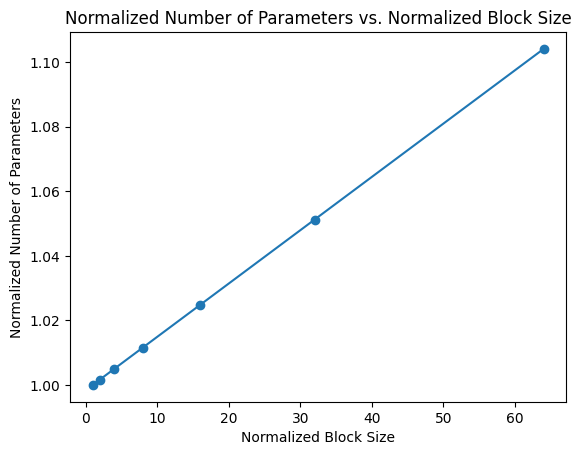

In [46]:
# Plot of the number of parameters vs. block size (in multiples of 8, capped at 512)
block_size_values = [8, 16, 32, 64, 128, 256, 512]
plot_param_vs_params(block_size_values, get_params, 'block_size', 'Block Size')


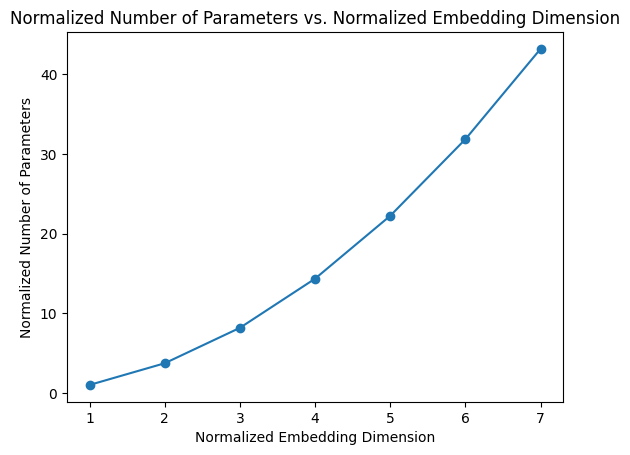

In [47]:
# Plot of the number of parameters vs. embedding dimension (in multiples of 256, capped at 1792)
emb_dim_values = [256, 512, 768, 1024, 1280, 1536, 1792]
plot_param_vs_params(emb_dim_values, get_params, 'emb_dim', 'Embedding Dimension')


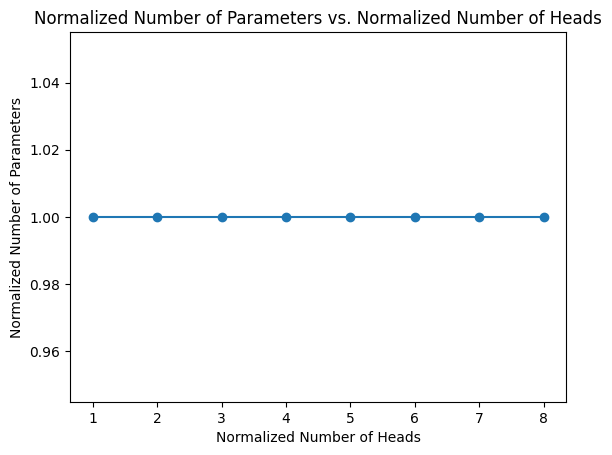

In [48]:
# Plot of the number of parameters vs. number of heads (in multiples of 4, capped at 32)
num_heads_values = [4, 8, 12, 16, 20, 24, 28, 32]
plot_param_vs_params(num_heads_values, get_params, 'num_heads', 'Number of Heads')


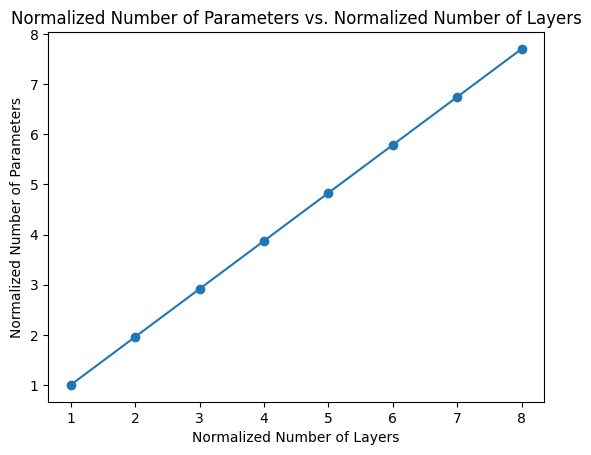

In [49]:
# Plot of the number of parameters vs. number of layers
num_layers_values = [1, 2, 3, 4, 5, 6, 7, 8]
plot_param_vs_params(num_layers_values, get_params, 'num_layers', 'Number of Layers')


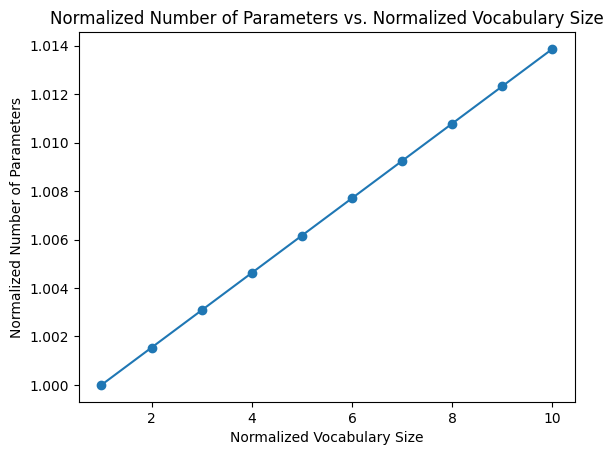

In [50]:
# Plot of the number of parameters vs. vocabulary size
vocab_size_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
plot_param_vs_params(vocab_size_values, get_params, 'vocab_size', 'Vocabulary Size')